In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from numba import njit 
import seaborn as sns 
import pandas as pd
from IPython.display import display
import os

In [2]:
np.random.seed(12345)

# 3.1 & 3.2
First of all let's start by simulating the process of filling our hard drives. As said in the exercise text in a realistic setting we would use a hash function, but here it suffices to assign files randomly with uniform probability to any hard drive; this is true because an "asymmetric" hash (i.e. one that preferentially fills e.g. HD 0) would never be actually utilized, hence asymptotically the uniform distribution will behave similarly to a realistic hash.            
Let's say we're working with 10 1TB HDDs (as said in the exercise text) and with files of `filesize` GB; then our "Montecarlo" algorithm to simulate the storage process works as follows:
- we create an empty length-10 vector `x`, so that its element represent the amount of stored data in the drives at any given time;
- we initiate a loop where as long as no hard drive has reached 1 TB (1000 GB) we sample uniformly an integer `i` in $[0,9]$, then increment `x[i]` by `filesize`;
- when one drive i.e. one `x` component reaches 1000 GB we stop.        

Once we have this vector we can use a barplot to represent the insides of our simulated drives.

x in GB (filesize = 10 GB): [ 860.  760.  790.  730. 1000.  750.  770.  820.  790.  840.]
x in GB (filesize = 1 GB): [ 963.  982.  946.  986.  986.  974.  985.  950. 1000.  987.]
x in GB (filesize = 0.004 GB): [ 995.56  1000.     998.304  998.16   999.448  996.9    995.148  998.76
  994.728  997.956]


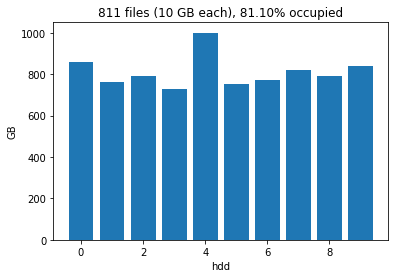

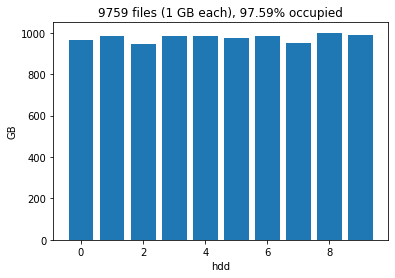

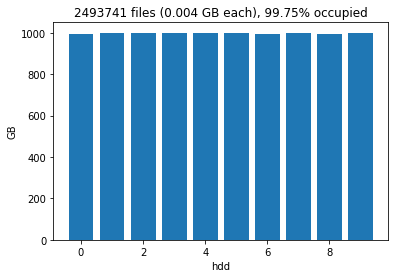

In [3]:
@njit
def populate_drives(filesize) :
    x = np.zeros(10)

    while (x < 1000).all() : # 1 TB = 1000 GB
        x[np.random.randint(10)] += filesize 
    return x 

def populate_and_plot_drives(filesize, verbose = True) :
    x = populate_drives(filesize)
    if verbose :
        print(f"x in GB ({filesize = } GB):", x)
    fig, ax = plt.subplots()
    ax.bar(np.arange(10), x)
    # we add to the plot 2 informations: how many files were successfully written + how much storage out of the 10 TBs we were able to use
    ax.set_title(f"{int(x.sum()/filesize)} files ({filesize} GB each), {x.sum()/1e4:.2%} occupied") # x.sum() = tot. n. of GB saved, x.sum()/1e4 = occupied fraction of the 10 available TBs
    ax.set_xlabel("hdd")
    ax.set_ylabel("GB");

    return x

list_of_file_sizes = [10, 1, 4e-3] # the assignment asks to make plots for filesize = 10 GB, 1 GB, 4 MB
list_of_drives = []

for i in list_of_file_sizes :
    list_of_drives.append(populate_and_plot_drives(i))

## 3.1a & 3.1b
With this seed the first execution of the above cells yields the following results.

In [4]:
def summary(x, f) :
    return f"{f} GB files: we wrote {int(x.sum()/f)} files i.e. {int(x.sum()/f)}*{f} = {x.sum():.2f} GBs of data" + "\n" + f"we were able to exploit {x.sum():.0f}/10000 = {x.sum()/1e4:.4f} = {x.sum()/1e4:.2%} of the available space"

print(summary(list_of_drives[0], list_of_file_sizes[0]))

10 GB files: we wrote 811 files i.e. 811*10 = 8110.00 GBs of data
we were able to exploit 8110/10000 = 0.8110 = 81.10% of the available space


If the simulation cell is executed again multiple times (without resetting the seed) one usually finds values between 80% and 92% (mostly centered around ~85%); this relatively large spread is analyzed below.

## 3.2a & 3.2b
With this seed the first execution of the simulation cell yields the following results.     

In [5]:
print(summary(list_of_drives[1], list_of_file_sizes[1]))

1 GB files: we wrote 9759 files i.e. 9759*1 = 9759.00 GBs of data
we were able to exploit 9759/10000 = 0.9759 = 97.59% of the available space


This time the results are "tighter", in the sense that if the cell is re-executed without a seed reset one typically finds values between 92% and 97% (mostly centered around ~95-96%), and gives us the first hint that smaller file size equals more efficient exploitation of space. *Why does this happen?*

## 3.3
With this seed the first execution of the simulation cell yields the following results.     

In [6]:
print(summary(list_of_drives[2], list_of_file_sizes[2]))

0.004 GB files: we wrote 2493741 files i.e. 2493741*0.004 = 9974.96 GBs of data
we were able to exploit 9975/10000 = 0.9975 = 99.75% of the available space


With a 4 MB file size it's basically impossible to find numbers outside the range 99.5-99.8% by manually re-executing the code cell. *Why is this the case?*             
We also notice that the smaller the file size the flatter the obtained distribution. Once again we ask: *but why?*

## Increasing efficiency explanation        
We can explain the above results using a simple semi-quantitative argument based on the law of large numbers as follows.                     
Let's temporarily imagine that $n$, the number of files we write/the number of iterations the algorithm runs, is not a random variable, but actually a predetermined constant (for example fixed in advance by us). If this is the case then the number of files we are able to store inside drive $i$ obeys a *binomial distribution* with $p = 0.1$; this follows from the fact that at each algorithm iteration every hard drive has a 10% chance of being "chosen" by our uniform generator, therefore every iteration is equivalent to one Bernoulli trial per hard disk (hence the binomial, by "accumulation" of Bernoulli trials). This fact is useful because it lets us give an order of magnitude estimate of how large $n$ needs to be to actually fill almost all of the available space.         
Indeed let's say that we chose $n$ such that on average each hard drive is almost full (in order to reproduce the 80-90%+ occupied storage values we observed empirically); this implies that if $n_i$ is the number of files in drive $i$ we then have
\begin{equation}
  \mathrm{E}[X_i] = \mathrm{E}[n_i f] \approx 1000 \ \text{GB}
\end{equation}
where we defined $X_i$ as the number of occupied GBs in drive $i$ and $f$ as the constant size of a single file.              
Since 
\begin{equation}
  n_i \sim \text{Binom}(n, p = 0.1) \quad \forall i = 1,\dots, 10
\end{equation}
we obtain by linearity:
\begin{equation}
  \mathrm{E}[X_i] = \mathrm{E}(n_i f) = n p_i f = \frac{nf}{10} \approx 1000 \ \text{GB} \quad \forall i = 1,\dots, 10
\end{equation}
Hence:
\begin{equation}
  f \frac{n}{10} \approx 1000 \ \text{GB} \implies n \approx \frac{10^4 \ \text{GB}}{f}
\end{equation}
If we want to be more precise we can write:
\begin{equation}
  n \lesssim \frac{10^4 \ \text{GB}}{f}
\end{equation}
since all $X_i$ but one are strictly $< 10^4 \ \text{GB}$ when the algorithm stops.       
The result that $n \propto 1/f$ approximately is quite intuitive and reasonable, since to cover the same fixed distance with smaller steps more time is needed.

For completeness let us remark that in the unluckiest case possible (at least in principle) every file will end up in the same HD, which means that the algorithm will only last $10^3/f$ iterations (since a single hard drive can only fit 1000 GBs of data); hence 
\begin{equation}
  \frac{10^3 \ \text{GB}}{f} \leq n \lesssim \frac{10^4 \ \text{GB}}{f}
\end{equation}
but this result is purely of academic interest; for all practical purposes it suffices to say $n$ will always be slightly less than $10^4/f$.                      

Even though this estimate for the upper bound on $n$ was obtained using a somewhat simplistic model it actually yields a pretty close number to the "experimental" results (as shown in the next cell); it also correctly reproduces the scaling of the problem (notice that when we go from $f = 10 \ \text{GB}$ from $f = 1 \ \text{GB}$ we save ~1 o.o.m. more files, and similarly when $f$ drops to $4 \ \text{MB}$ we gain another 3 extra o.o.m.'s).

In [7]:
def estimate_n(filesize) :
    return 1e4/filesize


for x, f in zip(list_of_drives, list_of_file_sizes) :
    observed_n = x.sum()/f
    predicted_n = estimate_n(f)
    print(f"relative difference between observed {observed_n} and predicted {predicted_n} ({f} GB): {np.abs(predicted_n - observed_n)/predicted_n:.2%}")

relative difference between observed 811.0 and predicted 1000.0 (10 GB): 18.90%
relative difference between observed 9759.0 and predicted 10000.0 (1 GB): 2.41%
relative difference between observed 2493741.000008267 and predicted 2500000.0 (0.004 GB): 0.25%


Now that we can somewhat satifyingly explain/predict the observed values of $n$ we can explain why the efficiency increases, why the histogram gets flatter with decreasing $f$ and why the above approximation gets better with smaller $f$'s.                
The above equations say that the smaller $f$ the longer the algorithm will last; indeed as we already remarked for these values of $f$ $n$ is almost guaranteed to be close to its theoretical maximum. We also notice that even in the worst case scenario we can be sure that, if $f_1,\  f_2, \ f_3 = 10 \ \text{GB}, \ 1 \ \text{GB}, \ 0.004 \ \text{GB}$ respectively then we will have $n_1 \leq 10 n_2$ and $n_2 \leq 1000 n_3$ - so that 4 MB files make $n$ inevitably huge.                 
Using the above we obtain:
\begin{equation}
  100 \leq n_1 \lesssim 1000
\end{equation}
\begin{equation}
  1000 \leq n_2 \lesssim 10^4
\end{equation}
\begin{equation}
  2.5 \cdot 10^5 \leq n_3 \lesssim 2.5\cdot10^6
\end{equation}
This means that the smaller $f$ the more random numbers we sample from the uniform distribution, and therefore *the closer we get to having a flat distribution* (by the law of large numbers); this already explains the observed shapes! But if a small $f$ makes the empirical distribution closer to the theoretical uniform one then it means that *the smaller $f$ the closer the bin heights*; this in turn guarantees that all bins have a height very close to the one of the full drive, which stopped the algorithm. This finally gives two important results:
- With a smaller $f$ all of the $X_i$'s (i.e. GBs stored in drive $i$) become almost equal to each other, and in particular to the one which reached 1 TB; this means that smaller $f$ == higher efficiency/percentage of overall occupied storage.
- Due to the above the smaller $f$ the more "constant" the $X_i$'s become, which means their std gets much smaller since they all get closer to their ideal unknown mean. Notice that as they all get closer to 1 TB the assumption $\mathrm{E}(X_i) \approx 1 \ \text{TB}$ becomes more and more correct, which makes our $n \approx 10^4/f$ result less of a simplistic approximation and more of an actual prediction; this explains why as $f$ gets smaller this approximation gets better and better.

*To recap*: with smaller values of $f$ more files will need to be written before any hard drive is full, which means we're sampling a lot more uniform random numbers and therefore obtaining a distribution very close to uniform. By "flatness" this makes all bins approximately as tall as the one that reached 1 TB, hence we get closer to filling 100% of the available space (while also making our formula more correct).

Notice that this increase in efficiency increases monotonically with a decreasing $f$, which seems to suggest that going even further than 4 MB is desirable; this is actually not true due to other reasons. In particular notice that a typical computer is able to process 4 MB much more efficiently than single bytes, hence 4 MB offers a pretty good compromise between storage efficiency and IOPS - while at the same time making individual blocks much lighter to e.g. move around the internet (which is relevant if the hard drives are far away) compared to, say, 1 GB (which would offer comparable efficiency).

## 3.4
Let's organize our results in a small dataframe for visual clarity's sake.

In [8]:
df = pd.DataFrame(np.vstack((list_of_file_sizes, list(map(np.mean, list_of_drives)), list(map(np.std, list_of_drives)))).T, columns = ["filesize", "mean", "std"])
display(df) # obviously the mean is just tot GB written / 10, i.e. we obtain x.sum() once again but divided by 10

,filesize,mean,std
0,10.000,811.0000,73.817342
1,1.000,975.9000,16.621973
2,0.004,997.4964,1.739587


We already explained why the mean scales as $1/f$: smaller files $\implies$ more files are written $\implies$ more numbers are sampled from the uniform distribution $\implies$ the resulting histogram is closer to flat $\implies$ the rectangles' heights get closer $\implies$ each drive's content becomes closer to the full one $\implies$ the overall storage efficiency increases.            
This long chain can also explain why the standard deviation of the sample decreases with $f$; indeed as we know $\sigma$ measures the amount of variability in the observed dataset, which is why
\begin{equation}
  \text{constant data points} \implies \sigma = 0
\end{equation}
\begin{equation}
  \text{wildly different data points} \implies \sigma \gg 1
\end{equation}
This suffices to explain the decreasing $\sigma$ behaviour: since a smaller and smaller $f$ makes the drives closer and closer to full we obtain that
\begin{equation}
  \text{smaller $f$} \implies \text{almost constant $\vec{x}$ components} \implies \text{smaller $\sigma$}
\end{equation}

Let's now repeat the experiment for many times and plot how the random variable "% of occupied space" is distributed.

In [9]:
@njit
def obtain_drive_statistic(filesize, n_experiments = 1000, percent = True) :
    y = np.zeros(n_experiments)
    for i in range(n_experiments) :
        y[i] = populate_drives(filesize).sum()
    if percent :
        return y/1e4
    else :
        return y

def plot_drive_statistic(filesize, n_experiments = 1000) :
    y = obtain_drive_statistic(filesize, n_experiments) 
    fig, ax = plt.subplots()
    ax.hist(y)
    ax.set_title(f"{n_experiments} experiments, {filesize} GB filesize")
    ax.set_xlabel("% of occupied space");

    return y

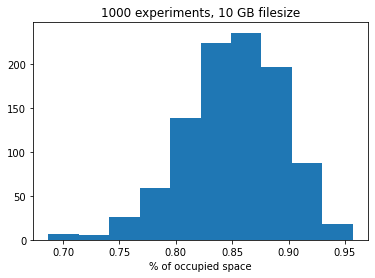

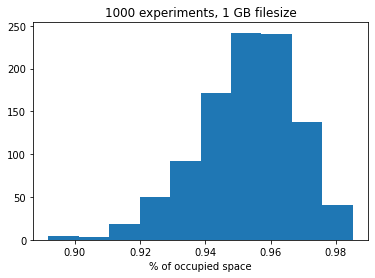

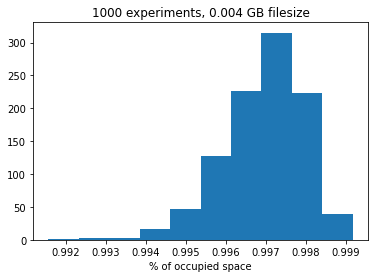

In [10]:
# since the histogram for 4 MB takes a bit of time to speed up debugging we save the results
save = True

if not os.path.exists("./df1.csv") :
    l = [plot_drive_statistic(f) for f in list_of_file_sizes]
    df1 = pd.DataFrame(np.array(l).T, columns = [str(f) for f in list_of_file_sizes])
    if save :
        df1.to_csv("df1.csv", index = False)
    #display(df1)
else :
    df1 = pd.read_csv("df1.csv")
    for i in range(3) :
        fig, ax = plt.subplots()
        ax.hist(df1.iloc[:,i])
        ax.set_title(f"1000 experiments, {df1.columns[i]} GB filesize")
        ax.set_xlabel(r"% of occupied space");

We obtained gaussian-like distribution. This is not surprising due to the central limit theorem; indeed we expect that as the number of experiment grows this distribution becomes closer and closer to a gaussian with mean equal to the "true" mean (with the same holding for the standard deviation). Due to what we already explained the "true" mean scales inversely with $f$, whereas the "true" std scales proportionally with $f$; this explains why the last histogram is so much "tighter" horizontally and more on the right wrt the first, etc.

In [11]:
# even though 1000 experiments aren't that many they nonetheless allow us to obtain more solid estimates for the random variable "% of occupied storage"
def experiments_summary(x, f) :
    m, s = x.mean(), x.std()
    return f"occupied storage ({f} GB files): {m:.2%} +- {s:.2%}"

for i in range(3) :
    print(experiments_summary(df1.iloc[:,i], list_of_file_sizes[i]))

occupied storage (10 GB files): 85.08% +- 4.33%
occupied storage (1 GB files): 95.27% +- 1.51%
occupied storage (0.004 GB files): 99.69% +- 0.10%


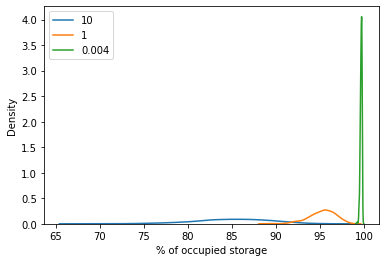

In [12]:
# if we want we can do fancy things like a kde

for i in range(3) :
    sns.kdeplot(100*df1.iloc[:,i], label = list_of_file_sizes[i])

plt.xlabel(r"% of occupied storage")
plt.legend(loc = "best");
# indeed the 4 MB gaussian is much tighter than the others, and almost centered around 100%

## Appendix: more rigorous derivation of the $n$ average upper bound estimate computed above
A more careful statistical modelling of the problem can let us obtain results analogous to what we already derived, but in a less "hand-wavy" fashion; let's start with some notation.        
Let $n_i$ ($i=0, \dots, 9$) be the number of files in hard drive $i$. If the whole process stopped when e.g. drive 0 is full (instead of the first which reaches 1 TB) then the vector $(n_0, \dots, n_9)$ would be distributed according to a *negative multinomial* with $\vec{p} = (0.1, \dots, 0.1)$ (since each drive has a 10% prob. of being "chosen" at any given iteration) and $r = 1000 \ \text{GB}/f$ (since by definition  $r$ is the number of successes in slot 0 after which the process stops). Hence we write:
\begin{equation}
  (n_0, n_1, \dots, n_9) \sim \text{NM}\left(r = \frac{1000 \ \text{GB}}{f}, \ \vec{p} = (0.1, 0.1, \dots, 0.1) \right)
\end{equation}
The above relation holds independently of which drive decides when the process stops.              
In our problem, though, it's not necessarily drive 0 which stops the algorithm; this means we need to do the following.                     
1) First we marginalize the above wrt every index but one; by symmetry this will give us the distribution of any $n_i$.             
2) Then we compute the distribution of the sum of all $n_i$'s, because this will give us the distribution of $n = \sum_{i=0}^9 n_i$.                  
According to [this wikipedia page](https://en.wikipedia.org/wiki/Negative_multinomial_distribution) the following two facts hold:
- The marginal of a negative multinomial wrt variable $i$ is a *negative binomial* with the same $r$ and $p_i$ rescaled in such a way that $p_0+p_i=1$. This lets us solve point 1); indeed we obtain 
\begin{equation}
  n_i \sim \text{NB}\left(r' = r = \frac{1000 \ \text{GB}}{f}, \ p' = 5p = \frac{1}{2} \right)
\end{equation}
- The random variable "sum of two positive/negative binomial/multinomial distributions with the same $p$/$\vec{p}$" is a distribution of the same kind, with the same $p$/$\vec{p}$ and the other parameter equal to the sum of the two $n$/$r$'s; this lets us solve point 2), since if combined with the previous bullet point it implies that 
\begin{equation}
  n \sim \text{NB}\left(r = \frac{10^4 \ \text{GB}}{f}, \ p = \frac{1}{2}\right)
\end{equation}  
   
Notice that $n$'s distribution cannot actually be a NB, since the probability of $n$ surpassing the max value is 0 (whereas the NB has no such constraint); this means that if we want to compute e.g. $\langle n\rangle$ we need to "cut" the rightmost part of the distribution, which means that $\langle n \rangle$ is slightly less than $\langle \ \text{NB}(r = 10^4 \ \text{GB}/f, \ p = 1/2) \ \rangle$. Since 
\begin{equation}
  \Bigg\langle \text{NB}\left(r = \frac{10^4 \ \text{GB}}{f}, \ p = \frac{1}{2}\right) \Bigg\rangle = \frac{pr}{1-p} = \frac{10^4 \ \text{GB}}{f}
\end{equation}
we obtain 
\begin{equation}
  \langle n \rangle \lesssim \frac{10^4 \ \text{GB}}{f}
\end{equation}
which is *the same result we already obtained*, but in a more "professional" way. As a bonus we can also produce approximations for other interesting quantities, such as the std. 